### A python file to calculate the spikes frequency between left and right in the LFPs data 

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

In [2]:
a = [0,1,0,0,0,0,0,1,0,1,0,0,0,1,0]
b = [0,0,1,0,0,0,0,0,1,0,1,0,0,0,1]

grp = "SNC"
caseid = "2820A"
gm = 0.014

filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/'+str(grp)+'/'+str(caseid)+'_'+str(gm)+'.csv'
df = pd.read_csv(filename)
a = df.iloc[:,5].to_numpy()
b = df.iloc[:,6].to_numpy()
peaks_a, _ = find_peaks(a, prominence=1)
peaks_b,_ = find_peaks(b, prominence=1)
np_a = np.zeros((1,81920))
np_a[:,peaks_a] = 1

np_b = np.zeros((1,81920))
np_b[:,peaks_b] = 1

a = np_a[0]
b = np_b[0]

In [3]:

def signal_corr(x, y, interval=int(81920/100)):
    interval = np.arange(0, len(a), interval)
    si_list = []
    sj_list = []
    for i in range(len(interval)-1):
        si_list.append(np.sum(a[interval[i]:interval[i+1]]))
        sj_list.append(np.sum(b[interval[i]:interval[i+1]]))

    vi = np.mean(si_list)
    vj = np.mean(sj_list)

    tau_list_pos = []
    for i in range(len(si_list)-1):
        cij_tau = np.mean(si_list[i]*sj_list[i+1]) - vi*vj
        tau_list_pos.append(cij_tau)
    tau_list_neg = []
    for i in range(1,len(si_list)):
        _cij_tau = np.mean(si_list[i]*sj_list[i-1]) - vi*vj
        tau_list_neg.append(_cij_tau)
    par1 = tau_list_neg[::-1]
    par1.extend(tau_list_pos)
    cij = []
    for i in range(len(par1)):
        _cij = par1[i]* (len(a) - np.abs(interval[1]-interval[0]))/len(a)
        cij.append(_cij)

    return cij



In [8]:
path = '/home/yat-lok/workspace/data4project/lateralization/tvb_parameters.xlsx'
coData = pd.read_excel(path)

co = pd.DataFrame()
for grp, caseid in zip(coData.groups, coData.caseid):
    gm = np.round(coData.loc[coData['caseid'] == caseid, 'Gc'].item(), 3)
    filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/'+str(grp)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    # filename = '/mnt/w/gc3mins/'+grp+'/'+caseid+'.h5'
    df = pd.read_csv(filename)
    a = df.iloc[:,5]
    b = df.iloc[:,6]
    peaks_a, _ = find_peaks(a, prominence=1)
    peaks_b,_ = find_peaks(b, prominence=1)
    np_a = np.zeros((1,81920))
    np_a[:,peaks_a] = 3
    np_b = np.zeros((1,81920))
    np_b[:,peaks_b] = 3
    a = np_a[0]
    b = np_b[0]
    corr = np.array(signal_corr(a,b,2000))/2000
    _tmp = pd.DataFrame([{"group":grp, "caseid":caseid, "sig_corr":np.sum(corr)}])
    co = pd.concat([co, _tmp], ignore_index=True)

[]

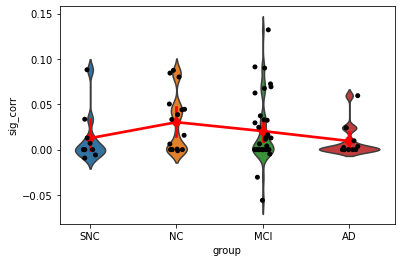

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x="group", y="sig_corr", data=co, inner = None, width=0.7, bw=0.2)
sns.stripplot( x="group", y="sig_corr", data=co, color='black', label="right")
sns.pointplot(x="group", y="sig_corr", data=co, estimator=np.mean, color = 'red')
plt.plot()